# Emotion Detection

**Importing Libraries**

In [ ]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

**Exploring Dataset**

In [ ]:
images = glob("train/**/**")
for i in range(9):
    image = random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image));plt.axis('off')

**Preparing Data for Training**

In [ ]:
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator()
train_generator = datagen_train.flow_from_directory("train/",
                                                   target_size = (img_size,img_size),
                                                   color_mode = "grayscale",
                                                   batch_size = batch_size,
                                                   class_mode = "categorical",
                                                   shuffle = True)

datagen_validation = ImageDataGenerator()
validation_generator = datagen_train.flow_from_directory("test/",
                                                   target_size = (img_size,img_size),
                                                   color_mode = "grayscale",
                                                   batch_size = batch_size,
                                                   class_mode = "categorical",
                                                   shuffle = True)

**Defining Model**

In [ ]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Dropout(0.25)(x)
    
    return x

In [ ]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    
    return x

In [ ]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs,32,(3,3))
    conv_2 = Convolution(conv_1,64,(5,5))
    conv_3 = Convolution(conv_2,128,(3,3))

    flatten = Flatten()(conv_3)
    
    dense_1 = Dense_f(flatten,256)

    output  = Dense(7, activation="softmax")(dense_1)
    model  =  Model(inputs=[inputs],outputs = [output])
    
    model.compile(loss=['categorical_crossentropy'] , optimizer = 'adam' , metrics =["accuracy"])

    return model

In [ ]:
model = model_fer((48,48,1))
model.summary()

**Initializing the Model**

In [ ]:
epochs = 3
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model.weights.h5", monitor  ='val_accuracy', save_weights_only = True, mode = 'max', verbose =1)
callbacks = [checkpoint]

# Traning the Model

**The next cell takes time to complete**

In [13]:
history = model.fit(
x = train_generator,
steps_per_epoch = steps_per_epoch,
epochs = epochs,
validation_data = validation_generator,
validation_steps = validation_steps,
callbacks = callbacks)

448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3207 - loss: 1.7868

c:\Users\Dr.Harry\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 978s 2s/step - accuracy: 0.3209 - loss: 1.7865 - val_accuracy: 0.3926 - val_loss: 1.6673
Epoch 2/3
  1/448 ━━━━━━━━━━━━━━━━━━━━ 6:52 922ms/step - accuracy: 0.3750 - loss: 1.6015
Epoch 2: saving model to model.weights.h5


c:\Users\Dr.Harry\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3750 - loss: 1.6015 - val_accuracy: 0.2000 - val_loss: 1.8321
Epoch 3/3
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4620 - loss: 1.4089
Epoch 3: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 612s 1s/step - accuracy: 0.4620 - loss: 1.4089 - val_accuracy: 0.4696 - val_loss: 1.4019


**Model Evaluation**

In [14]:
model.evaluate(validation_generator)

113/113 ━━━━━━━━━━━━━━━━━━━━ 31s 275ms/step - accuracy: 0.4743 - loss: 1.4313


[1.4015743732452393, 0.46990805864334106]

**Plotting Loss**

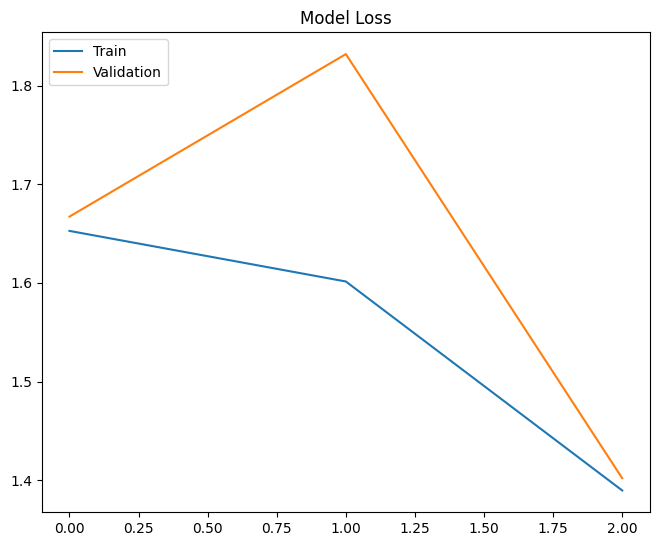

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right =0.95,left=0.0,hspace=0.25,wspace=0.35)

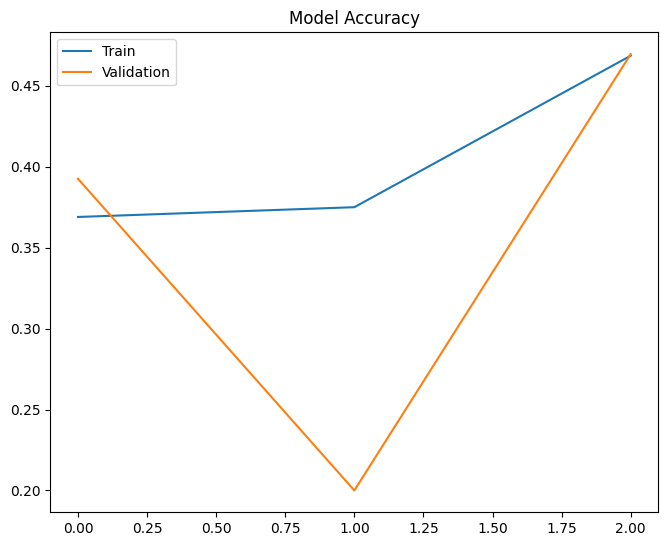

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right =0.95,left=0.0,hspace=0.25,wspace=0.35)

**Saving Model**

In [17]:
model_json = model.to_json()
with open("model_a.json","w") as json_file:
    json_file.write(model_json)